# Creating a Flow with custom classes for Producers, Transformers, and Consumers

## Introduction

This notebook introduces the object-oriented API of *fluxus*. You will learn how to:

- create your own classes for producers, transformers, and consumers
- compose these conduits using the `>>` operator for chaining and the `&` operator for concurrent execution
- build flows for asynchronous execution using the asynchronous versions of the classes

## Overview

Flows consist of building blocks that create, transform, or collect data items.
We call these data items *products*, and the building blocks *conduits*.

There are three types of conduits:

- **Producers**: These generate products.
- **Transformers**: These modify or process the products.
- **Consumers**: These collect the final products.

## Creating Conduit classes

To build your own flow using the object-oriented API, you first need to define classes for the conduits in your flow (for an easier start with *fluxus*, consider first experimenting with the *functional* API where all products are dictionaries, and no custom classes are required).

All of these classes must be a subclass of one of `Producer`, `Transformer`, or `Consumer`. All of these classes are subclasses of `Conduit`.

We will show examples for defining producers, transformers and consumers in the following sections, and will then use these to build and run a complete flow. 

### Producers

When creating a `Producer` subclass, you need to specify the type of products it generates using a type hint. Implement the `produce` method to yield products of this type.

Imagine a scenario where the `Producer` generates a sequence of numbers:

In [1]:
from collections.abc import Iterator
from fluxus import Producer
from fluxus.core.transformer._transformer_base import (
    T_SourceProduct_arg,
    T_TransformedProduct_ret,
)


class NumberProducer(Producer[int]):

    def __init__(self, n: int) -> None:
        self.n = n

    def produce(self) -> Iterator[int]:
        yield from range(1, self.n + 1)

Note that the type hint for the `Producer` parent class matches the type hint for the iterator.

Producers are *iterable* so we can easily test them by iterating over them:

In [2]:
list(NumberProducer(5))

[1, 2, 3, 4, 5]

### Transformers

When creating a `Transformer` subclass, you need to specify the input and output (product) types using type hints. Implement the `transform` method to process input products and yield transformed products of the specified output type.

In our example, we will use `Transformer` classes to perform mathematical operations. We will create one transformer that doubles each number and another that calculates the square.


In [3]:
from fluxus import Transformer


class DoublingTransformer(Transformer[int, int]):
    def transform(self, x: int) -> Iterator[int]:
        yield x * 2


class SquareTransformer(Transformer[int, int]):
    def transform(self, x: int) -> Iterator[int]:
        yield x * x

Once more, note that the type hints used for the `Transformer` base class match the input and output types of the `transform` method.

### Consumers

When creating a `Consumer` subclass, you need to specify the type of products it consumes and the type of output it generates using type hints (use `None` as the output type if there is no output).
Implement the `consume` method to handle the consumed products.

The following `Consumer` collects all processed numbers into a list.
Note that the consumer method receives products as an iterator of tuples, where the first element is the index of the path taken through the flow and the second element is the product itself.
The index is useful when the flow branches into multiple paths, and you want to distinguish between the products generated by each path.
We will explore this in more detail further down.

In [4]:
from fluxus import Consumer


class NumberConsumer(Consumer[int, list[int]]):
    def consume(self, products: Iterator[tuple[int, int]]) -> list[int]:
        # ignore the path index and return the numbers
        return list(number for _, number in products)

## Building a flow

Now that we have defined the classes for the conduits, we can build a flow by chaining them together using the `>>` operator.

In this example, we will generate numbers from 1 to 5, double then square them, and then collect the results in a list.

The flow is constructed as follows:

In [5]:
flow = (
    NumberProducer(n=5)
    >> DoublingTransformer()
    >> SquareTransformer()
    >> NumberConsumer()
)

The `>>` operator chains the conduits together, passing the product of one conduit as the input to the next.

If *Graphviz* is installed, we can visualize the flow:

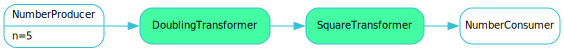

In [6]:
flow

Note that the graph includes the `n` property of the `NumberProducer`.
All `__init__` parameters of a conduit that have a matching instance attribute will be included in representations of the flow, as is the case with the `n` parameter of the `NumberProducer`.

More styles are available via the `style` argument of the `draw` method:

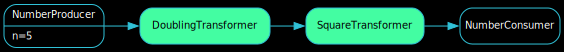

In [7]:
flow.draw(style="graph_dark")

We can now run the flow:

In [8]:
flow.run()

[4, 16, 36, 64, 100]

## Parallel flows

In many cases, you will want to run multiple conduits concurrently.
This can be achieved using the `&` operator.

In the following example, we will generate numbers from 1 to 5.
For each of these numbers, we will once calculate the square and once the doubled value, in parallel.
We will then collect the results in a list.

The flow is constructed as follows:

In [9]:
flow = (
    NumberProducer(n=5)
    >> (DoublingTransformer() & SquareTransformer())
    >> NumberConsumer()
)

The flow looks like this:

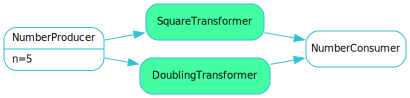

In [10]:
flow

We run the flow as before:

In [11]:
flow.run()

[2, 4, 6, 8, 10, 1, 4, 9, 16, 25]

### The `Passthrough` transformer

In the previous example, we used the `&` operator to run two transformers in parallel.
A special `Passthrough` transformer can be included in a parallel composition of conduits to pass the input product through without modification.

Applying the `Passthrough` transformer to the previous example, we get:

In [12]:
from fluxus import Passthrough

flow_passthrough = (
    NumberProducer(n=5)
    >> (DoublingTransformer() & SquareTransformer() & Passthrough())
    >> NumberConsumer()
)

The flow looks like this:

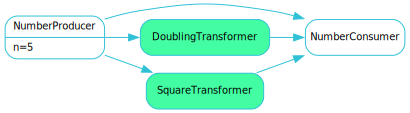

In [13]:
flow_passthrough

Running the flow:

In [14]:
flow_passthrough.run()

[2, 4, 6, 8, 10, 1, 4, 9, 16, 25, 1, 2, 3, 4, 5]

## Asynchronous Flows

The real power of the object-oriented API is that it allows you to run conduits concurrently using Python's asynchronous capabilities.
To do this, you need to use the `async` versions of the producer, transformer, and consumer classes:
`AsyncProducer`, `AsyncTransformer`, and `AsyncConsumer`.

Instead of implementing the `produce`, `transform`, and `consume` methods, you need to implement the `aproduce`, `atransform`, and `aconsume` methods, respectively. Calls to the original methods will create an event loop and will defer the execution of the asynchronous methods.

In the following example, we will run the same flow as before, but this time we will use the asynchronous versions of the classes.

In [15]:
import random
import asyncio
from collections.abc import AsyncIterator
from fluxus import AsyncProducer, AsyncTransformer, AsyncConsumer


class AsyncNumberProducer(AsyncProducer[int]):

    def __init__(self, n: int) -> None:
        self.n = n

    async def aproduce(self) -> AsyncIterator[int]:
        for i in range(1, self.n + 1):
            yield i


class AsyncDoublingTransformer(AsyncTransformer[int, int]):

    async def atransform(self, x: int) -> AsyncIterator[int]:
        yield x * 2


class AsyncSquareTransformer(AsyncTransformer[int, int]):

    async def atransform(self, x: int) -> AsyncIterator[int]:
        yield x * x


class AsyncNumberConsumer(AsyncConsumer[int, list[int]]):

    async def aconsume(self, products: AsyncIterator[tuple[int, int]]) -> list[int]:
        return [number async for _, number in products]


flow_async = (
    AsyncNumberProducer(n=5)
    >> AsyncDoublingTransformer()
    >> AsyncSquareTransformer()
    >> AsyncNumberConsumer()
)

If you are already inside an event loop (as is the case in Jupyter notebooks), you can run the asynchronous flow using the asynchronous `arun` method:

In [16]:
await flow_async.arun()

[4, 16, 36, 64, 100]

Alternatively, calling the synchronous `run` method on an asynchronous flow will create a new event loop behind the scenes and run the asynchronous methods from there:

In [17]:
flow_async.run()

[4, 16, 36, 64, 100]

While the above is a toy example which does not benefit from the asynchronous capabilities, asynchronous flows will bring dramatic performance improvements when dealing with I/O-bound tasks, such as calls to remote APIs or database queries.

## Concluding remarks

In this notebook, we have demonstrated how to create custom classes for producers, transformers, and consumers.
We have built a flow by chaining these conduits together using the `>>` operator.
We have also shown how to run multiple conduits concurrently using the `&` operator, and have introduced the `Passthrough` transformer, which can be used to pass the input product through without modification.
Finally, we have demonstrated how to create and run asynchronous flows using the asynchronous versions of the classes.